In [1]:
# default_exp retrieval

# Data Retrieval

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fdev-01-retrieval.ipynb)

This notebook outlines the retrieval of the fuel generation and price data required for the merit-order-effect analyses.

<br>

### Imports

In [3]:
#exports
import json
import numpy as np
import pandas as pd

import requests
import xmltodict
from tqdm import tqdm
from datetime import date
from warnings import warn

from dotenv import load_dotenv
from entsoe import EntsoePandasClient, EntsoeRawClient

In [4]:
import os
from IPython.display import JSON

<br>

### Electric Insights

Electric Insights provides a site to "Take a closer look at the supply, demand, price and environmental impact of Britain’s electricity", it also exposes an API that contains the data we require for this analysis

<br>

#### Single Stream

We'll being by retrieving data for a single stream only, starting with just the raw JSON response

In [5]:
#exports
def query_API(start_date:str, end_date:str, stream:str, time_group='30m'):
    """
    'Query API' makes the call to Electric Insights and returns the JSON response

    Parameters:
        start_date: Start date for data given as a string in the form '%Y-%m-%d'
        end_date: End date for data given as a string in the form '%Y-%m-%d'
        stream: One of 'prices_ahead', 'prices', 'temperatures', 'emissions', or 'generation-mix'
        time_group: One of '30m', '1h', '1d' or '7d'. The default is '30m'
    """

    # Checking stream is an EI endpoint
    possible_streams = ['prices_ahead', 'prices', 'temperatures', 'emissions', 'generation-mix']
    assert stream in possible_streams, f"Stream must be one of {''.join([stream+', ' for stream in possible_streams])[:-2]}"

    # Checking time_group will be accepted by API
    possible_time_groups = ['30m', '1h', '1d', '7d']
    assert time_group in possible_time_groups, f"Time group must be one of {''.join([time_group+', ' for time_group in possible_time_groups])[:-2]}"

    # Formatting dates
    format_dt = lambda dt: date.strftime(dt, '%Y-%m-%d') if isinstance(dt, date) else dt
    start_date = format_dt(start_date)
    end_date = format_dt(end_date)

    # Running query and parsing response
    response = requests.get(f'http://drax-production.herokuapp.com/api/1/{stream}?date_from={start_date}&date_to={end_date}&group_by={time_group}')
    r_json = response.json()

    return r_json

<br>

We can convert this response to a dataframe, however this doesn't handle the nested columns well

In [6]:
start_date = '2020-01-01'
end_date = '2020-01-31'
stream = 'emissions'
time_group = '30m'

r_json = query_API(start_date=start_date, end_date=end_date, stream=stream, time_group=time_group)
df = pd.DataFrame.from_dict(r_json)

df.head()

,start,end,value
0,2020-01-01T00:00:00Z,2020-01-01T00:30:00Z,"{'totalInTperh': 4445.670000000001, 'totalInGp..."
1,2020-01-01T00:30:00Z,2020-01-01T01:00:00Z,"{'totalInTperh': 4668.45, 'totalInGperkWh': 16..."
2,2020-01-01T01:00:00Z,2020-01-01T01:30:00Z,"{'totalInTperh': 4562.072, 'totalInGperkWh': 1..."
3,2020-01-01T01:30:00Z,2020-01-01T02:00:00Z,"{'totalInTperh': 4342.128, 'totalInGperkWh': 1..."
4,2020-01-01T02:00:00Z,2020-01-01T02:30:00Z,"{'totalInTperh': 4123.677, 'totalInGperkWh': 1..."


<br>

We can create a function that will take a specified column and extract the nested dataframe

In [7]:
#exports
def dict_col_to_cols(df:pd.DataFrame, value_col='value'):
    """Checks the `value_col`, if it contains dictionaries these are transformed into new columns which then replace it"""

    ## Checks the value col is found in the dataframe
    if value_col not in df.columns:
        return df

    if isinstance(df.loc[0, value_col], dict):
        df_values = pd.DataFrame(df[value_col].to_dict()).T
        df[df_values.columns] = df_values
        df = df.drop(columns=[value_col])

    return df

In [8]:
df = dict_col_to_cols(df)

df.head(3)

,start,end,totalInTperh,totalInGperkWh
0,2020-01-01T00:00:00Z,2020-01-01T00:30:00Z,4445.670,162.398904
1,2020-01-01T00:30:00Z,2020-01-01T01:00:00Z,4668.450,167.502063
2,2020-01-01T01:00:00Z,2020-01-01T01:30:00Z,4562.072,166.268387


<br>

Unfortunately however this doesn't handle repeated nesting of dictionaries, we'll create a wrapper that does

In [9]:
#exports
def clean_nested_dict_cols(df):
    """Unpacks columns contining nested dictionaries"""
    # Calculating columns that are still dictionaries
    s_types = df.iloc[0].apply(lambda val: type(val))
    cols_with_dicts = s_types[s_types == dict].index

    while len(cols_with_dicts) > 0:
        for col_with_dicts in cols_with_dicts:
            # Extracting dataframes from dictionary columns
            df = dict_col_to_cols(df, col_with_dicts)

            # Recalculating columns that are still dictionaries
            s_types = df.iloc[0].apply(lambda val: type(val))
            cols_with_dicts = s_types[s_types == dict].index
            
    return df

In [10]:
df = clean_nested_dict_cols(df)

df.head()

,start,end,totalInTperh,totalInGperkWh
0,2020-01-01T00:00:00Z,2020-01-01T00:30:00Z,4445.670,162.398904
1,2020-01-01T00:30:00Z,2020-01-01T01:00:00Z,4668.450,167.502063
2,2020-01-01T01:00:00Z,2020-01-01T01:30:00Z,4562.072,166.268387
3,2020-01-01T01:30:00Z,2020-01-01T02:00:00Z,4342.128,163.385260
4,2020-01-01T02:00:00Z,2020-01-01T02:30:00Z,4123.677,159.122875


<br>

Next we'll process the datetime index

In [11]:
#exports
def set_dt_idx(df:pd.DataFrame, idx_name='local_datetime'):
    """
    Converts the start datetime to UK local time, then sets it as the index and removes the original datetime columns
    """

    idx_dt = pd.DatetimeIndex(pd.to_datetime(df['start'], utc=True)).tz_convert('Europe/London')
    idx_dt.name = idx_name

    df.index = idx_dt
    df = df.drop(columns=['start', 'end'])

    return df

def create_df_dt_rng(start_date, end_date, freq='30T', tz='Europe/London', dt_str_template='%Y-%m-%d'):
    """
    Creates a dataframe mapping between local datetimes and electricity market dates/settlement periods
    """
    
    # Creating localised datetime index
    s_dt_rng = pd.date_range(start_date, end_date, freq=freq, tz=tz)
    s_dt_SP_count = pd.Series(0, index=s_dt_rng).resample('D').count()

    # Creating SP column
    SPs = []
    for num_SPs in list(s_dt_SP_count):
        SPs += list(range(1, num_SPs+1))

    # Creating datetime dataframe
    df_dt_rng = pd.DataFrame(index=s_dt_rng)
    df_dt_rng.index.name = 'local_datetime'

    # Adding query call cols
    df_dt_rng['SP'] = SPs
    df_dt_rng['date'] = df_dt_rng.index.strftime(dt_str_template)

    return df_dt_rng

def clean_df_dts(df):
    """Cleans the datetime index of the passed DataFrame"""
    df = set_dt_idx(df)
    df = df[~df.index.duplicated()] 

    df_dt_rng = create_df_dt_rng(df.index.min(), df.index.max())
    df = df.reindex(df_dt_rng.index)

    df['SP'] = df_dt_rng['SP'] # Adding settlement period designation
    
    return df

In [12]:
df = clean_df_dts(df)

df.head()

,totalInTperh,totalInGperkWh,SP
local_datetime,,,
2020-01-01 00:00:00+00:00,4445.670,162.398904,1
2020-01-01 00:30:00+00:00,4668.450,167.502063,2
2020-01-01 01:00:00+00:00,4562.072,166.268387,3
2020-01-01 01:30:00+00:00,4342.128,163.385260,4
2020-01-01 02:00:00+00:00,4123.677,159.122875,5


<br>

We'll now combine all of the previous steps and add some column renaming where we want to tidy them up a bit

In [13]:
#exports
def retrieve_stream_df(start_date:str, end_date:str, stream:str, time_group='30m', renaming_dict={}):
    """
    Makes the call to Electric Insights and parses the response into a dataframe which is returned

    Parameters:
        start_date: Start date for data given as a string in the form '%Y-%m-%d'
        end_date: End date for data given as a string in the form '%Y-%m-%d'
        stream: One of 'prices_ahead', 'prices_ahead', 'prices', 'temperatures' or 'emissions'
        time_group: One of '30m', '1h', '1d' or '7d'. The default is '30m'
        renaming_dict: Mapping from old to new column names
    """

    # Calling data and parsing into dataframe
    r_json = query_API(start_date, end_date, stream, time_group)
    df = pd.DataFrame.from_dict(r_json)

    # Handling entrys which are dictionarys
    df = clean_nested_dict_cols(df)

    # Setting index as localised datetime, reindexing with all intervals and adding SP
    df = clean_df_dts(df)

    # Renaming value col
    if 'value' in df.columns:
        df = df.rename(columns={'value':stream})

    if 'referenceOnly' in df.columns:
        df = df.drop(columns=['referenceOnly'])

    df = df.rename(columns=renaming_dict)

    return df

In [43]:
start_date = '2009-01-01'
end_date = '2009-01-02'
stream = 'generation-mix'

renaming_dict = {
    'pumpedStorage' : 'pumped_storage',
    'northernIreland' : 'northern_ireland',
    'windOnshore': 'wind_onshore',
    'windOffshore': 'wind_offshore'
}

df = retrieve_stream_df(start_date, end_date, stream, renaming_dict=renaming_dict)

df.head()

,nuclear,biomass,coal,gas,hydro,wind,solar,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish,SP
local_datetime,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,6.973,0,17.650,11.900,0.246,0.148,0,38.329,-0.404,None,None,0.0,0.0,1.977,0.0,0.0,-0.161,1
2009-01-01 00:30:00+00:00,6.968,0,17.770,12.031,0.245,0.157,0,38.461,-0.527,None,None,0.0,0.0,1.977,0.0,0.0,-0.160,2
2009-01-01 01:00:00+00:00,6.970,0,18.070,11.754,0.246,0.147,0,37.986,-1.018,None,None,0.0,0.0,1.977,0.0,0.0,-0.160,3
2009-01-01 01:30:00+00:00,6.969,0,18.022,11.162,0.246,0.148,0,36.864,-1.269,None,None,0.0,0.0,1.746,0.0,0.0,-0.160,4
2009-01-01 02:00:00+00:00,6.960,0,17.998,10.812,0.246,0.160,0,36.180,-1.566,None,None,0.0,0.0,1.730,0.0,0.0,-0.160,5


<br>

#### Multiple Streams

We'll now create further functionality for retrieving all of the streams and combining them, before doing so we'll create a helper function for checking the streams are allowed

In [15]:
#exports
def check_streams(streams='*'):
    """
    Checks that the streams given are a list containing only possible streams, or is all streams - '*'.
    """
    
    possible_streams = ['prices_ahead', 'prices', 'temperatures', 'emissions', 'generation-mix']

    if isinstance(streams, list):
        unrecognised_streams = list(set(streams) - set(possible_streams))

        if len(unrecognised_streams) == 0:
            return streams 
        else:
            unrecognised_streams_to_print = ''.join(["'"+stream+"', " for stream in unrecognised_streams])[:-2]
            raise ValueError(f"Streams {unrecognised_streams_to_print} could not be recognised, must be one of: {', '.join(possible_streams)}")

    elif streams=='*':
        return possible_streams 

    else:
        raise ValueError(f"Streams could not be recognised, must be one of: {', '.join(possible_streams)}")

In [16]:
streams = check_streams()

streams

['prices_ahead', 'prices', 'temperatures', 'emissions', 'generation-mix']

<br>

By default all streams are returned but if we provide a list it will be checked

In [17]:
streams = check_streams(['prices', 'emissions'])

streams

['prices', 'emissions']

<br>

However, if we try to check a list containing a stream that doesn't exist we should receive an error

In [18]:
try:
    _ = check_streams(['not_a_stream'])
    print('Success!')
except Exception as e:
    print('Error!\n\n'+str(e))

Error!

Streams 'not_a_stream' could not be recognised, must be one of: prices_ahead, prices, temperatures, emissions, generation-mix


<br>

Next we'll create a wrapper for downloading and combining all of the streams together

In [19]:
#exports
def retrieve_streams_df(start_date:str, end_date:str, streams='*', time_group='30m', renaming_dict={}):
    """
    Makes the calls to Electric Insights for the given streams and parses the responses into a dataframe which is returned

    Parameters:
        start_date: Start date for data given as a string in the form '%Y-%m-%d'
        end_date: End date for data given as a string in the form '%Y-%m-%d'
        streams: Contains 'prices_ahead', 'prices_ahead', 'prices', 'temperatures' or 'emissions', or is given as all, '*'
        time_group: One of '30m', '1h', '1d' or '7d'. The default is '30m'
    """

    df = pd.DataFrame()
    streams = check_streams(streams)

    for stream in streams:
        df_stream = retrieve_stream_df(start_date, end_date, stream, renaming_dict=renaming_dict)           
        df[df_stream.columns] = df_stream

    return df

In [20]:
streams = '*'
renaming_dict = {
    'pumpedStorage' : 'pumped_storage',
    'northernIreland' : 'northern_ireland',
    'windOnshore': 'wind_onshore',
    'windOffshore': 'wind_offshore',
    'prices_ahead' : 'day_ahead_price',
    'prices' : 'imbalance_price',
    'temperatures' : 'temperature',
    'totalInGperkWh' : 'gCO2_per_kWh',
    'totalInTperh' : 'TCO2_per_h'
}

df = retrieve_streams_df(start_date, end_date, streams, renaming_dict=renaming_dict)

df.head()

,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,48.81,1,15.0,15.0,9.1,2287.010,83.662935,6.924,1.116,0,...,27.336,0.000,8.054581,3.141711,0.0,0.182,1.552,0.0,0.0,-0.702
2019-01-01 00:30:00+00:00,50.24,2,15.0,15.0,9.1,2467.906,89.023375,6.838,1.103,0,...,27.722,0.024,7.860487,3.253887,0.0,0.196,1.554,0.0,0.0,-0.696
2019-01-01 01:00:00+00:00,41.90,3,16.0,16.0,9.1,2411.834,87.888419,6.834,1.090,0,...,27.442,0.000,7.879198,3.340851,0.0,0.588,1.504,0.0,0.0,-0.722
2019-01-01 01:30:00+00:00,39.32,4,16.0,16.0,9.1,2119.532,80.072988,6.830,1.085,0,...,26.470,0.000,7.708874,3.213702,0.0,0.600,1.504,0.0,0.0,-0.770
2019-01-01 02:00:00+00:00,34.09,5,16.0,16.0,9.1,2069.840,79.016606,6.827,1.081,0,...,26.195,0.000,7.479429,3.122706,0.0,0.678,1.504,0.0,0.0,-0.910


<br>

Now we're ready to retrieve all of the streams in one, which we'll do for all years that data is available, then we'll save the resulting DataFrame.

In [250]:
#exports
def get_EI_data(
    start_date,
    end_date,
    streams='*',
    batch_freq='3M',
    renaming_dict={
        'pumpedStorage' : 'pumped_storage',
        'northernIreland' : 'northern_ireland',
        'windOnshore': 'wind_onshore',
        'windOffshore': 'wind_offshore',
        'prices_ahead' : 'day_ahead_price',
        'prices' : 'imbalance_price',
        'temperatures' : 'temperature',
        'totalInGperkWh' : 'gCO2_per_kWh',
        'totalInTperh' : 'TCO2_per_h'
    }
):
    # Preparing batch dates
    *batch_start_dates, post_batch_start_date = pd.date_range(start_date, end_date, freq=f'{batch_freq}S').strftime('%Y-%m-%d')
    pre_batch_end_date, *batch_end_dates = (pd.date_range(start_date, end_date, freq=batch_freq)+pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    batch_date_pairs = list(zip(batch_start_dates, batch_end_dates))

    if start_date != pre_batch_end_date:
        batch_date_pairs = [(start_date, pre_batch_end_date)] + batch_date_pairs

    if end_date != post_batch_start_date:
        end_date = (pd.to_datetime(end_date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        batch_date_pairs = batch_date_pairs + [(post_batch_start_date, end_date)]

    # Retrieving data
    df = pd.DataFrame()

    for batch_start_date, batch_end_date in tqdm(batch_date_pairs):
        df_batch = retrieve_streams_df(batch_start_date, batch_end_date, streams, renaming_dict=renaming_dict)
        df = df.append(df_batch)  
        
    return df

In [248]:
start_date = '2010-01-01'
end_date = '2020-12-31'

data_dir = '../data/raw'

retrieve_save_EI_data = False

if retrieve_save_EI_data == True:
    df = get_EI_data(start_date, end_date)
    df.to_csv(f'{data_dir}/electric_insights.csv')
else:
    df = pd.read_csv(f'{data_dir}/electric_insights.csv', parse_dates=['local_datetime'], index_col='local_datetime')

df.head()

,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

### Energy-Charts



We'll start by requesting the JSON that is used to populate the fuel-type output chart on the <a href="https://energy-charts.info/">website</a>

In [161]:
#exports
def year_week_to_prod_url(year, week, data_prefix=''): 
    """Given a specified year and week the relevant `production_url` for energy-charts is returned"""
    if year < 2019:
        data_prefix = 'raw_'
    
    production_url = f'https://energy-charts.info/charts/power/{data_prefix}data/de/week_{year}_{str(week).zfill(2)}.json'
    
    return production_url

In [162]:
year = 2018
week = 12

production_url = year_week_to_prod_url(year, week)

r = requests.get(production_url)

r

<Response [200]>

<br>

Next we focus on parsing the only non-uniform column which relates to the balancing required on the system

In [163]:
#exports
def fuel_json_to_net_balance(r_json):
    """Extracts the balance time-series"""
    if 'values' in r_json[0].keys(): # pre-2019 format
        df_balance = pd.DataFrame(r_json[0]['values'])

        s_balance = (df_balance
                     .assign(datetime=pd.to_datetime(df_balance[0]*1000000, utc=True))
                     .drop(columns=0)
                     .set_index('datetime')
                     .rename(columns={
                         1 : 'value',
                     })
                     ['value']
                    )
        
    else:
        s_balance = pd.Series(r_json[0]['data'], index=pd.to_datetime(np.array(r_json[0]['xAxisValues'])*1000000, utc=True))
        
    s_balance.index = s_balance.index.tz_convert('Europe/Berlin')
    
    return s_balance

In [164]:
# Retrieving net balance data
r_json = r.json()
s_balance = fuel_json_to_net_balance(r_json)

# Getting comments
data_src = r_json[0]['datasource']
comment = '\n'.join([item['en'] for item in r_json[0]['comment']])

print(data_src)
print(comment)

s_balance

50 Hertz, Amprion, Tennet, TransnetBW, EEX
Net generation of power plants for public power supply.


datetime
2018-03-19 00:00:00+01:00   -9.044
2018-03-19 01:00:00+01:00   -9.522
2018-03-19 02:00:00+01:00   -9.576
2018-03-19 03:00:00+01:00   -9.978
2018-03-19 04:00:00+01:00   -9.787
                             ...  
2018-03-25 19:00:00+02:00   -6.319
2018-03-25 20:00:00+02:00   -5.968
2018-03-25 21:00:00+02:00   -6.329
2018-03-25 22:00:00+02:00   -6.134
2018-03-25 23:00:00+02:00   -6.839
Name: value, Length: 167, dtype: float64

<br>

We can then combine this with a parser for the main columns

In [221]:
#exports
def response_to_df(r):
    """Parses the json response to a DataFrame"""
    r_json = r.json()
    s_balance = fuel_json_to_net_balance(r_json)

    if 'key' in r_json[1].keys(): # pre-2019
        keys = [x['key'][0]['en'] for x in r_json[1:]]
        values = [x['values'] for x in r_json[1:]]

        df_fuels = (pd.DataFrame(dict(zip(keys, values)), index=s_balance.index)
                    .apply(lambda s: s.apply(lambda x: x[-1]))
                    .assign(net_balance=s_balance)
                    .rename(columns={'net_balance': 'Net Balance'})
                   )
        
    else:
        cols = [x['name'][0]['en'] for x in r_json[1:]]
        data = [x['data'] for x in r_json[1:]]

        df_fuels = pd.DataFrame(np.array(data).T, columns=cols, index=s_balance.index).assign(net_balance=s_balance).rename(columns={'net_balance': 'Net Balance'})
        
    return df_fuels

In [214]:
df_fuels = response_to_df(r)

df_fuels.head(2)

,Hydro Power,Biomass,Uranium,Brown Coal,Hard Coal,Oil,Gas,Others,Pumped Storage,Seasonal Storage,Wind,Solar,Net Balance
datetime,,,,,,,,,,,,,
2018-03-19 00:00:00+01:00,2.292,5.82,7.721,14.499,8.508,0.180,3.207,0.068,0.420,0.078,20.754,0.0,-9.044
2018-03-19 01:00:00+01:00,2.291,5.82,7.829,14.490,8.941,0.179,3.287,0.068,0.245,0.064,19.012,0.0,-9.522


<br>

And wrap them in a single function which can accept a year and week before returning the parsed dataframe

In [167]:
#exports
def year_week_to_fuel_df(year, week):
    """Given a specified year and week the relevant `df_fuels` dataset for energy-charts is returned"""
    production_url = year_week_to_prod_url(year, week)

    r = requests.get(production_url)
    
    # This is a general catch-all but mainly added to account 
    # for years with 53 weeks rather than 52
    if r.status_code == 404:
        df_fuels = pd.DataFrame()
    else:
        df_fuels = response_to_df(r)
    
    return df_fuels

In [168]:
year = 2015
week = 53

df_fuels = year_week_to_fuel_df(year, week)

df_fuels.head(2)

,Hydro Power,Biomass,Uranium,Brown Coal,Hard Coal,Oil,Gas,Others,Pumped Storage,Seasonal Storage,Wind,Solar,net_balance
datetime,,,,,,,,,,,,,
2015-12-28 00:00:00+01:00,1.356,6,10.567,13.247,3.437,0.190,2.338,0.150,0.154,0.013,8.156,0.0,-3.923
2015-12-28 01:00:00+01:00,1.348,6,10.611,13.744,3.109,0.191,2.533,0.124,0.157,0.012,7.059,0.0,-4.139


<br>

Now we can iterate over all year and week pairs to retrieve the full dataset

In [236]:
#exports
def get_EC_data(
    start_date, 
    end_date,
    columns=['Biomass', 'Brown Coal', 'Gas', 'Hard Coal', 'Hydro Power',
             'Oil', 'Others', 'Pumped Storage', 'Seasonal Storage', 
             'Solar', 'Uranium', 'Wind', 'Net Balance'],
    new_api_rename_map={
        'Fossil Hard Coal': 'Hard Coal', 
        'Hydro Run-of-River': 'Hydro Power', 
        'Fossil Gas': 'Gas', 
        'Hydro Water Reservoir': 'Seasonal Storage', 
        'Hydro Pumped Storage': 'Pumped Storage', 
        'Fossil Brown Coal': 'Brown Coal', 
        'Fossil Oil': 'Oil', 
        'Nuclear': 'Uranium'
    }
):
    # Preparing batches
    adj_start_date = pd.to_datetime(start_date) - pd.Timedelta(weeks=1)
    adj_end_date = pd.to_datetime(end_date) + pd.Timedelta(weeks=1)

    dt_rng = pd.date_range(adj_start_date, adj_end_date, freq='W')
    year_week_pairs = list(zip(dt_rng.year, dt_rng.isocalendar().week))
    
    # Retrieving
    df_fuels = pd.DataFrame()

    for year, week in tqdm(year_week_pairs):
        try:
            df_fuels_yr_wk = year_week_to_fuel_df(year, week).rename(columns=new_api_rename_map)
            df_fuels = df_fuels.append(df_fuels_yr_wk, sort=True)
        except:
            warn(f'Failed to retrieve week {week} in {year}')
            
    # Cleaning
    df_fuels = (df_fuels
                [columns]
                .astype(float)
                .resample('H')
                .mean()
                .dropna(how='all', axis=1)
               )
    
    df_fuels = df_fuels[start_date:end_date]
    df_fuels.index.name = 'local_datetime'
            
    return df_fuels

In [237]:
start_date = '2021-05-01'
end_date = '2021-05-25'

df_EC = get_EC_data(start_date, end_date)
        
df_EC.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


,Biomass,Brown Coal,Gas,Hard Coal,Hydro Power,Oil,Others,Pumped Storage,Seasonal Storage,Solar,Uranium,Wind,Net Balance
local_datetime,,,,,,,,,,,,,
2021-05-01 00:00:00+02:00,5.19675,12.51975,6.56375,4.03900,NaN,0.148,0.35625,0.93950,0.02075,0.0,6.72275,2.28525,-0.0870
2021-05-01 01:00:00+02:00,5.19450,12.47475,5.57200,3.91175,NaN,0.148,0.34825,0.84875,0.01500,0.0,6.71075,2.28825,-0.0930
2021-05-01 02:00:00+02:00,5.20275,11.91850,5.10200,3.75925,NaN,0.148,0.35150,0.66350,0.00275,0.0,6.70950,2.14600,-0.1435


<br>

We'll quickly confirm that there are no duplicates

In [233]:
assert df_EC.index.duplicated().sum() == 0, 'There are multiple entries for a datetime'

<br>

Next we check for any missing datetimes, because there are only a few missing datetimes we'll choose to drop them from the dataset at a later step

In [244]:
s_null_vals = df_EC.isnull().sum(axis=1)==df_EC.shape[1]

print(f'{round(100*s_null_vals.mean(), 2)}% of the datetimes are missing data')
print(f"There are {(s_null_vals.resample('D').sum()>0).sum()} days with missing data, totalling {s_null_vals.sum()} hours of individual missing hours")

0.57% of the datetimes are missing data
There are 1 days with missing data, totalling 24 hours of individual missing hours


<br>

Finally we'll wrap these steps up and save the data

In [247]:
start_date = '2010-01-01'
end_date = '2020-12-31'

data_dir = '../data/raw'

retrieve_save_EC_data = False

if retrieve_save_EC_data == True:
    df_EC = get_EC_data(start_date, end_date)
    df_EC.to_csv(f'{data_dir}/energy_charts.csv')
else:
    df_EC = pd.read_csv(f'{data_dir}/energy_charts.csv', parse_dates=['local_datetime'], index_col='local_datetime')

df_EC.head()

,Biomass,Brown Coal,Gas,Hard Coal,Hydro Power,Oil,Others,Pumped Storage,Seasonal Storage,Solar,Uranium,Wind,net_balance
local_datetime,,,,,,,,,,,,,
2010-01-04 00:00:00+01:00,3.637,16.533,4.726,10.078,2.331,0.000,0.0,0.052,0.068,0.0,16.826,0.635,-1.229
2010-01-04 01:00:00+01:00,3.637,16.544,4.856,8.816,2.293,0.000,0.0,0.038,0.003,0.0,16.841,0.528,-1.593
2010-01-04 02:00:00+01:00,3.637,16.368,5.275,7.954,2.299,0.000,0.0,0.032,0.000,0.0,16.846,0.616,-1.378
2010-01-04 03:00:00+01:00,3.637,15.837,5.354,7.681,2.299,0.000,0.0,0.027,0.000,0.0,16.699,0.630,-1.624
2010-01-04 04:00:00+01:00,3.637,15.452,5.918,7.498,2.301,0.003,0.0,0.020,0.000,0.0,16.635,0.713,-0.731


<br>

### ENTSOE

We'll use ENTSOE as the source for our German price data, we'll also have to use it to get the exact RES and demand volumes for the bidding zone that Germany is within. 

<br>

##### Prices

We'll begin by initialising our client API for ENTSOE

**You will need to supply your own API key**

In [6]:
load_dotenv()
ENTSOE_API_KEY = os.environ['ENTSOE_API_KEY']

client = EntsoePandasClient(api_key=ENTSOE_API_KEY)

client

<br>

We'll then make a test request for price data from the German market

In [33]:
params = {
    'documentType': 'A44',
    'in_Domain': '10Y1001A1001A63L',
    'out_Domain': '10Y1001A1001A63L'
}

start = pd.Timestamp('2018-09-01', tz='UTC')
end = pd.Timestamp('2018-09-30', tz='UTC')

r = client._base_request(params=params, start=start, end=end)

r

<Response [200]>

<br>

We'll extract the price time-series from the returned JSON

In [34]:
#exports
def parse_A44_response(r, freq='H', tz='UTC'):
    """Extracts the price time-series"""
    s_price = pd.Series(dtype=float)
    parsed_r = xmltodict.parse(r.text)
    
    for timeseries in parsed_r['Publication_MarketDocument']['TimeSeries']:
        dt_rng = pd.date_range(timeseries['Period']['timeInterval']['start'], timeseries['Period']['timeInterval']['end'], freq=freq, tz=tz)[:-1]
        s_dt_price = pd.DataFrame(timeseries['Period']['Point'])['price.amount'].astype(float)
        s_dt_price.index = dt_rng
        s_price = s_price.append(s_dt_price)
    
    assert s_price.index.duplicated().sum() == 0, 'There are duplicate date indexes'
    
    return s_price

In [35]:
s_price = parse_A44_response(r)

s_price.head()

2018-08-31 22:00:00+00:00    57.58
2018-08-31 23:00:00+00:00    55.99
2018-09-01 00:00:00+00:00    55.56
2018-09-01 01:00:00+00:00    54.02
2018-09-01 02:00:00+00:00    52.69
Freq: H, dtype: float64

<br>

We can't query very large date ranges so we'll break up our requests into quarterly batches. 

We'll also account for the fact that the German market changes to exclude Austria after 2018-10-01 by creating two sets of date pairs.

In [36]:
DE_AT_LU_dt_pairs = list(zip(
    pd.date_range('2015', '2018-07', freq='3MS').strftime('%Y-%m-%d %H:%M'), 
    pd.date_range('2015-03-31 23:55', '2018-09-30 23:55', freq='3M').strftime('%Y-%m-%d %H:%M')
))

DE_AT_LU_dt_pairs[:5]

[('2015-01-01 00:00', '2015-03-31 23:55'),
 ('2015-04-01 00:00', '2015-06-30 23:55'),
 ('2015-07-01 00:00', '2015-09-30 23:55'),
 ('2015-10-01 00:00', '2015-12-31 23:55'),
 ('2016-01-01 00:00', '2016-03-31 23:55')]

<br>

We're now ready to create a wrapper to collate the date from each date batch

In [37]:
#exports
def retreive_DAM_prices(dt_pairs, domain='10Y1001A1001A63L'):
    """Retrieves and collates the day-ahead prices for the specified date ranges"""
    params = {
        'documentType': 'A44',
        'in_Domain': domain,
        'out_Domain': domain
    }

    s_price = pd.Series(dtype=float)

    for dt_pair in tqdm(dt_pairs):
        start = pd.Timestamp(dt_pair[0], tz='UTC')
        end = pd.Timestamp(dt_pair[1], tz='UTC')

        try:
            r = client._base_request(params=params, start=start, end=end)

            s_price_dt_rng = parse_A44_response(r)
            s_price = s_price.append(s_price_dt_rng)
        except:
            warn(f"{start.strftime('%Y-%m-%d')} - {end.strftime('%Y-%m-%d')} failed")
        
    return s_price

In [38]:
s_price_DE_AT_LU = retreive_DAM_prices(DE_AT_LU_dt_pairs)
    
s_price_DE_AT_LU.head()

 [████████████████████████████████████████████████████████████] 15/15 [00:20<00:01, 1.31s/it]

2015-01-04 23:00:00+00:00    22.34
2015-01-05 00:00:00+00:00    17.93
2015-01-05 01:00:00+00:00    15.17
2015-01-05 02:00:00+00:00    16.38
2015-01-05 03:00:00+00:00    17.38
dtype: float64

<br>

We'll repeat this for the market excluding Austria

In [39]:
DE_LU_dt_pairs = list(zip(
    pd.date_range('2018-10', '2021-01', freq='3MS').strftime('%Y-%m-%d %H:%M'), 
    pd.date_range('2018-12-31 23:55', '2021-02-28 23:55', freq='3M').strftime('%Y-%m-%d %H:%M')
))

s_price_DE_LU = retreive_DAM_prices(DE_LU_dt_pairs, domain='10Y1001A1001A82H')
    
s_price_DE_LU.head()

 [████████████████████████████████████████████████████████████] 9/9 [00:11<00:01, 1.25s/it]

2018-09-30 22:00:00+00:00    59.53
2018-09-30 23:00:00+00:00    56.10
2018-10-01 00:00:00+00:00    51.41
2018-10-01 01:00:00+00:00    47.38
2018-10-01 02:00:00+00:00    47.59
dtype: float64

<br>

We'll now combine and visualise the time-series

<AxesSubplot:>

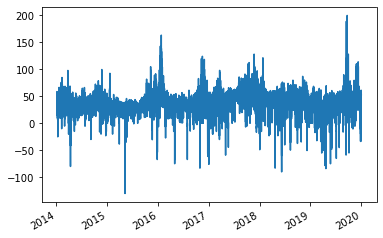

In [40]:
s_price = s_price_DE_AT_LU.append(s_price_DE_LU)
s_price.index = s_price.index.tz_convert('Europe/Berlin')

s_price.plot()

<br>

Before moving on we'll save this series as a csv

In [41]:
s_price.name = 'DE_price'
s_price.index.name = 'local_datetime'

s_price.to_csv('../data/raw/ENTSOE_DE_price.csv')

<br>

##### Generation by Fuel-Type

We'll now create the functions for retrieving and parsing the fuel data

In [42]:
#exports
def parse_A75_response(r, freq='15T', tz='UTC', warn_on_failure=False):
    """Extracts the production data by fuel-type from the JSON response"""
    psr_code_to_type = {
        'A03': 'Mixed',
        'A04': 'Generation',
        'A05': 'Load',
        'B01': 'Biomass',
        'B02': 'Fossil Brown coal/Lignite',
        'B03': 'Fossil Coal-derived gas',
        'B04': 'Fossil Gas',
        'B05': 'Fossil Hard coal',
        'B06': 'Fossil Oil',
        'B07': 'Fossil Oil shale',
        'B08': 'Fossil Peat',
        'B09': 'Geothermal',
        'B10': 'Hydro Pumped Storage',
        'B11': 'Hydro Run-of-river and poundage',
        'B12': 'Hydro Water Reservoir',
        'B13': 'Marine',
        'B14': 'Nuclear',
        'B15': 'Other renewable',
        'B16': 'Solar',
        'B17': 'Waste',
        'B18': 'Wind Offshore',
        'B19': 'Wind Onshore',
        'B20': 'Other',
        'B21': 'AC Link',
        'B22': 'DC Link',
        'B23': 'Substation',
        'B24': 'Transformer'
    }
    
    parsed_r = xmltodict.parse(r.text)
    
    columns = [f'B{str(fuel_idx).zfill(2)}' for fuel_idx in np.arange(1, 24)]
    index = pd.date_range(
        parsed_r['GL_MarketDocument']['time_Period.timeInterval']['start'], 
        parsed_r['GL_MarketDocument']['time_Period.timeInterval']['end'], 
        freq=freq, tz=tz)[:-1]
    
    df_production = pd.DataFrame(dtype=float, columns=columns, index=index)
    
    for timeseries in parsed_r['GL_MarketDocument']['TimeSeries']:
        try:
            psr_type = timeseries['MktPSRType']['psrType']
            dt_rng = pd.date_range(timeseries['Period']['timeInterval']['start'], timeseries['Period']['timeInterval']['end'], freq=freq, tz=tz)[:-1]

            s_psr_type = pd.DataFrame(timeseries['Period']['Point'])['quantity'].astype(float)
            s_psr_type.index = dt_rng

            df_production[psr_type] = s_psr_type
            
        except:
            if warn_on_failure == True:
                warn(f"{timeseries['Period']['timeInterval']['start']}-{timeseries['Period']['timeInterval']['start']} failed for {psr_type}")
    
    assert df_production.index.duplicated().sum() == 0, 'There are duplicate date indexes'
    
    df_production = df_production.dropna(how='all').dropna(how='all', axis=1)
    df_production = df_production.rename(columns=psr_code_to_type)
    
    return df_production

def retrieve_production(dt_pairs, domain='10Y1001A1001A63L', warn_on_failure=False):
    """Retrieves and collates the production data for the specified date ranges"""
    params = {
        'documentType': 'A75',
        'processType': 'A16',
        'in_Domain': domain
    }

    df_production = pd.DataFrame(dtype=float)

    for dt_pair in tqdm(dt_pairs):
        start = pd.Timestamp(dt_pair[0], tz='UTC')
        end = pd.Timestamp(dt_pair[1], tz='UTC')

        try:
            r = client._base_request(params=params, start=start, end=end)

            df_production_dt_rng = parse_A75_response(r, warn_on_failure=warn_on_failure)
            df_production = df_production.append(df_production_dt_rng)
        except:
            if warn_on_failure == True:
                warn(f"{start.strftime('%Y-%m-%d')} - {end.strftime('%Y-%m-%d')} failed")
        
    return df_production

In [43]:
df_production_DE_AT_LU = retrieve_production(DE_AT_LU_dt_pairs)
df_production_DE_LU = retrieve_production(DE_LU_dt_pairs, domain='10Y1001A1001A82H')

df_production = df_production_DE_AT_LU.append(df_production_DE_LU)

df_production.head()

 [████████████████████████████████████████████████████████████] 15/15 [05:37<00:18, 22.45s/it]

 [████████████████████████████████████████████████████████████] 9/9 [02:37<00:14, 17.45s/it]

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore,Other,Marine
2015-01-01 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,391.0,0.0,NaN,NaN
2015-01-01 23:15:00+00:00,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,292.0,0.0,NaN,NaN
2015-01-01 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,271.0,0.0,NaN,NaN
2015-01-01 23:45:00+00:00,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,266.0,0.0,NaN,NaN
2015-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,268.0,0.0,NaN,NaN


<br>

We'll quickly inspect for the presence of null values, due to the large number found we'll use the energy-charts data when it comes to fuel generation

In [44]:
df_production.isnull().mean()

Biomass                            0.068175
Fossil Brown coal/Lignite          0.068175
Fossil Coal-derived gas            0.998617
Fossil Gas                         0.385562
Fossil Hard coal                   0.068175
Fossil Oil                         0.362709
Geothermal                         0.068175
Hydro Pumped Storage               0.068175
Hydro Run-of-river and poundage    0.068175
Hydro Water Reservoir              0.250576
Nuclear                            0.269564
Other renewable                    0.068175
Solar                              0.178234
Waste                              0.068175
Wind Offshore                      0.157710
Wind Onshore                       0.141564
Other                              0.068175
Marine                             0.979668
dtype: float64

In [13]:
#hide
from nbdev.export import *
notebook2script()

Converted dev-01-retrieval.ipynb.
Converted dev-02-eda.ipynb.
Converted dev-03-lowess.ipynb.
Converted dev-04-price-surface-estimation.ipynb.
Converted dev-05-price-moe.ipynb.
Converted dev-06-carbon-surface-estimation-and-moe.ipynb.
Converted dev-07-prediction-confidence-and-intervals.ipynb.
Converted dev-08-hyper-parameter-tuning.ipynb.
Converted dev-09-tables-and-figures.ipynb.
Converted dev-10-ci-cd.ipynb.
Converted ug-01-hydro-seasonality.ipynb.
Converted ug-02-ligo.ipynb.
Converted ug-03-power-curve.ipynb.
Converted ug-04-electricity-prices.ipynb.
Converted ug-05-data-retrieval.ipynb.
Converted ug-06-surface-estimation.ipynb.
Converted ug-07-moe-quantification.ipynb.
Converted ug-08-lowess-quick-start.ipynb.
